# Notebook 3: Bifurcation Diagram

**Objective:** To create a one-parameter bifurcation diagram. This shows how the long-term behavior of the system (e.g., the concentration of the top predator `z`) changes as a key parameter is varied. We will look for transitions from stable points to oscillations (Hopf bifurcations).

In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Add project root to path
if '..' not in sys.path:
    sys.path.append('..')

from config import get_params
from chemostat_analysis.simulation import run_simulation
from chemostat_analysis.visualization import plot_bifurcation_diagram

/Users/xuanthanhnguyen/Library/CloudStorage/OneDrive-HanoiUniversityofScienceandTechnology/2024-1/Leftt/2024-2/Maths Modelling/code/chemostat_foodchain_analyzer/notebooks/../chemostat_analysis/equilibria.py:3: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  from scipy.optimize import fsolve, root_scalar


### Bifurcation Diagram Construction

We will choose a base set of parameters (the "oscillations" scenario) and use `a3` (the removal rate of the top predator) as our bifurcation parameter. For each value of `a3` in a given range, we will:
1. Run the simulation for a long time to let transients die out.
2. Record the minimum and maximum values of the state variable `z` during the final part of the simulation.
3. Plot these min/max values against the parameter `a3`.

If the system converges to a stable point, the min and max will be the same. If it converges to a limit cycle, they will be different, tracing the bounds of the oscillation.

In [ ]:
base_params = get_params("tame_oscillations")

# Bifurcation parameter: a3
bifurcation_param_name = 'a3'
# Let's also adjust the range slightly to focus on the interesting part
param_range = np.linspace(0.01, 0.1, 150)

# Simulation settings
t_transient = 1500
t_record = 500
t_span = (0, t_transient + t_record)

# A safe, generic initial condition
safe_U0 = np.array([0.5, 0.5, 0.2, 0.2])
U0 = safe_U0.copy()

results = []

# Loop over the parameter range
for param_val in tqdm(param_range, desc="Generating Bifurcation Diagram"):
    current_params = base_params.copy()
    current_params[bifurcation_param_name] = param_val
    
    sol = run_simulation(U0, current_params, t_span, t_eval_count=5000)
    
    if sol.success and isinstance(sol.y, np.ndarray) and np.all(np.isfinite(sol.y[:, -1])):
        U0 = sol.y[:, -1]
        record_indices = sol.t > t_transient
        z_values = sol.y[3, record_indices]
        
        if len(z_values) > 0 and np.all(np.isfinite(z_values)):
            z_min = z_values.min()
            z_max = z_values.max()
            results.append((param_val, z_min, z_max))
        else:
            #  print(f"Warning: Non-finite values in recording period for {bifurcation_param_name} = {param_val:.4f}.")
             U0 = safe_U0.copy()
    else:
        status = "failed" if not sol.success else "produced non-finite results"
        print(f"Warning: Simulation {status} for {bifurcation_param_name} = {param_val:.4f}. Resetting.")
        U0 = safe_U0.copy()

bifurcation_data = np.array(results)

### Plotting the Bifurcation Diagram

Bifurcation data saved to: ../results/data/bifurcation_data_a3.csv
Plot saved to: ../results/plots/bifurcations/bifurcation_a3.png


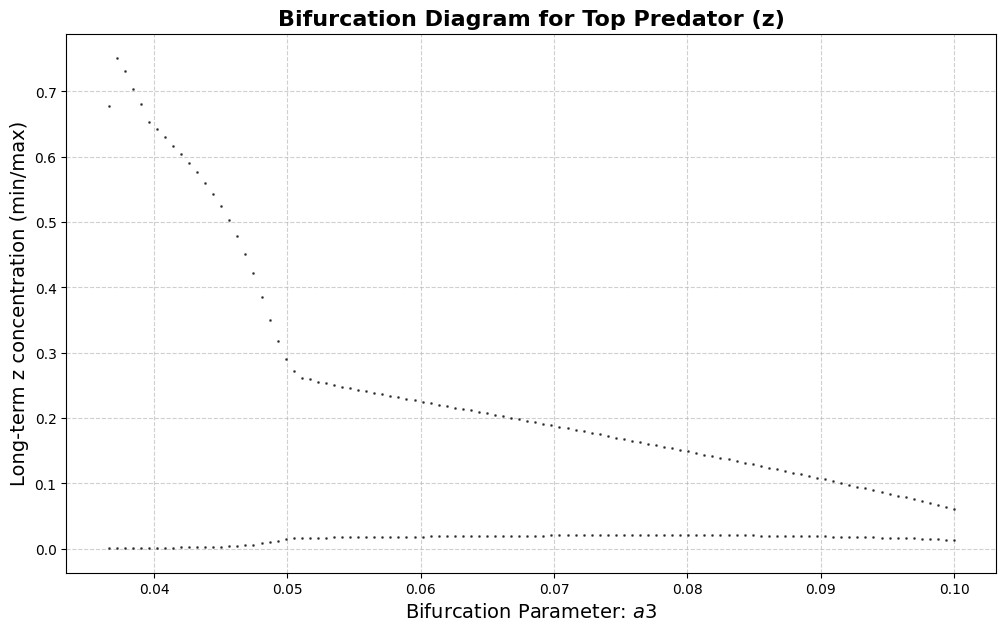

In [3]:
if bifurcation_data.size > 0:
    # 1. Save the computed data to a CSV file
    data_save_path = f'../results/data/bifurcation_data_{bifurcation_param_name}.csv'
    os.makedirs(os.path.dirname(data_save_path), exist_ok=True)
    np.savetxt(data_save_path, bifurcation_data, delimiter=',', header=f'{bifurcation_param_name},z_min,z_max', comments='')
    print(f"Bifurcation data saved to: {data_save_path}")

    # 2. Plot the diagram and save the figure
    plot_save_path = f'../results/plots/bifurcations/bifurcation_{bifurcation_param_name}.png'
    # --- FIX THE TYPO HERE ---
    plot_bifurcation_diagram(bifurcation_data, bifurcation_param_name, save_path=plot_save_path)
else:
    print("\nBifurcation data is empty. All simulations may have failed. No plot will be generated.")